In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/abie/projects/2023/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [3]:
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                               'age_start': 40,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-11-06 06:57:03.603 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-11-06 06:57:03.605 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-11-06 06:57:03.609 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,alive,exit_time,age,location,sex,entrance_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_multiplier,ldlc_medication,sbp_medication_adherence,ldlc_therapeutic_inertia_constant_component,sbp_therapeutic_inertia_constant_component,polypill,lifestyle_adherence,last_fpg_test_date,visit_type,scheduled_date
0,True,alive,NaT,62.325405,Alabama,Female,2020-12-04,not_dead,0.0,,...,1.3620,medium_intensity,cat3,0.095895,-0.050506,cat2,False,NaT,none,NaT
1,True,alive,NaT,56.583394,Alabama,Male,2020-12-04,not_dead,0.0,,...,1.5125,high_intensity,cat3,0.528809,0.901321,cat2,False,NaT,none,2021-03-21 23:06:47.554560
2,True,alive,NaT,63.072592,Alabama,Female,2020-12-04,not_dead,0.0,,...,1.0000,no_treatment,cat3,0.558211,-0.448101,cat2,True,NaT,none,NaT
3,True,alive,NaT,50.472918,Alabama,Male,2020-12-04,not_dead,0.0,,...,1.0000,low_intensity,cat3,-0.027969,0.133548,cat2,True,NaT,none,NaT
4,True,alive,NaT,49.552787,Alabama,Female,2020-12-04,not_dead,0.0,,...,1.3620,medium_intensity,cat2,-0.353543,-0.216679,cat2,True,NaT,none,NaT


In [5]:
#pop0.columns

In [6]:
#sim.list_values()

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                  ], axis=1)
data1.head()

,tracked,alive,exit_time,age,location,sex,entrance_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,sbp_medication_adherence,ldlc_therapeutic_inertia_constant_component,sbp_therapeutic_inertia_constant_component,polypill,lifestyle_adherence,last_fpg_test_date,visit_type,scheduled_date,high_sbp,high_sbp_raw
0,True,alive,NaT,62.325405,Alabama,Female,2020-12-04,not_dead,0.0,,...,cat3,0.095895,-0.050506,cat2,False,NaT,none,NaT,147.192049,147.192049
1,True,alive,NaT,56.583394,Alabama,Male,2020-12-04,not_dead,0.0,,...,cat3,0.528809,0.901321,cat2,False,NaT,none,2021-03-21 23:06:47.554560,145.689753,145.689753
2,True,alive,NaT,63.072592,Alabama,Female,2020-12-04,not_dead,0.0,,...,cat3,0.558211,-0.448101,cat2,True,NaT,none,NaT,94.942811,94.942811
3,True,alive,NaT,50.472918,Alabama,Male,2020-12-04,not_dead,0.0,,...,cat3,-0.027969,0.133548,cat2,True,NaT,none,NaT,148.753688,165.153688
4,True,alive,NaT,49.552787,Alabama,Female,2020-12-04,not_dead,0.0,,...,cat2,-0.353543,-0.216679,cat2,True,NaT,none,NaT,139.227528,139.227528


In [8]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
#data1.loc[data1.sbp_medication != 'no_treatment']

## Running time forward 

In [9]:
discontinue_risk = .314/12  # probability of discontinuing treatment during a single time step
# to be applied for the first year of treatment

In [10]:
## This is the function that reset people on meds back to no treatment. 
## I would expect that this is where you will make edits 

global_medication_start = None

def reset_sbp_medication(pop_t, current_timestep):
    ##Call the component with treatment 
    treatment = sim.get_component('treatment')
    ##Get a population view 
    data = treatment.population_view.get(pop_t.index)
    
    global global_medication_start
    if global_medication_start is None: # initialize medication start data
        global_medication_start = pd.Series(-1_000, index=pop_t.index) # this negative value means "not on treatment"
        
        # for individual initially on treatment, pick a random time for them to have been on
        rows_to_initialize_differently = (data['ldlc_medication'] != 'no_treatment')
        global_medication_start[rows_to_initialize_differently] = -np.random.choice(range(36),
                                                                                   size=sum(rows_to_initialize_differently))
        
        # for individuals *not* initially on treatment, pick a random set of them to have already stopped treatment
        # TODO: this should be age dependent
        rows_to_initialize_differently = (data['ldlc_medication'] == 'no_treatment')
        global_medication_start[rows_to_initialize_differently] = -np.random.choice([999, 1_000],
                                                                                   size=sum(rows_to_initialize_differently),
                                                                                   p=[.3,.7])
        
    # undo treatment for any -999 rows
    no_med_rows = (global_medication_start == -999)
    data.loc[no_med_rows, 'ldlc_medication'] = 'no_treatment'

    # record timestep that this changed
    new_med_rows = (data['ldlc_medication'] != 'no_treatment') & (global_medication_start == -1_000)
    global_medication_start[new_med_rows] = current_timestep
    
    
    ##Actual edit the data 
    ##More specifically this is where we will make edits to have the first year reset 
    rows_to_consider = ((data['ldlc_medication'] != 'no_treatment')
                        & (global_medication_start >= current_timestep - 12))
    
    indices_to_change = rows_to_consider & (np.random.uniform(size=len(rows_to_consider)) <= discontinue_risk)
    data.loc[indices_to_change, 'ldlc_medication'] = 'no_treatment'
    global_medication_start[indices_to_change] = -999  # this negative value means "was on treatment, but not anymore"
    
    ##Update the data in the population view with the new dataframe that was edited 
    treatment.population_view.update(data)
    return 

In [ ]:
%%time

## I would reset this to 1 time step or 5 time steps to test it 

sim_data = pd.DataFrame()
for step in list(range(0,250)):
    sim.step()
    pop_t = sim.get_population()
    reset_sbp_medication(pop_t, step) 
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_ldl_cholesterol.raw_exposure')(pop0.index).rename('high_ldl_raw'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                       ],axis=1)
    data_t['step'] = step
    data_t_small = data_t[['sex','age','alive','high_sbp', 'high_sbp_raw', 'high_ldl','high_ldl_raw','ldlc_medication','step']]
    print(step)
    sim_data = pd.concat([sim_data, data_t_small])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


In [ ]:
## Save the data - I find this helpful so that if things happen overnight (internet outage, jupyter crash) I still have a copy 

sim_data.to_csv('/ihme/homes/lutzes/ldl_data_250steps_11_6_23.csv')

# Read in Data and Analysis 

In [2]:
data = pd.read_csv('/ihme/homes/lutzes/ldl_data_250steps_11_6_23.csv')

In [3]:
data1 = data.loc[(data.age > 25) & (data.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1['sex_numeric'] = np.where(data1.sex == 'Male', 1, 0)
data1['ascvd'] = -19.5 + (0.043 * data1.high_sbp) + (0.266 * data1.age) + (2.32 * data1.sex_numeric)
data1['need_meds'] = np.where((data1.age > 70) & (data1.high_ldl_raw > 3.48), 1, 0)
data1['need_meds'] = np.where((data1.ascvd > 7.5) & (data1.high_ldl_raw > 1.81), 1, 0)

In [12]:
data_need_med = data1.loc[data1.need_meds == 1]
data_need_med.head()

,Unnamed: 0,sex,age,alive,high_sbp,high_sbp_raw,high_ldl,high_ldl_raw,ldlc_medication,step,age_start,sex_numeric,ascvd,need_meds
9,9,Male,73.945806,alive,153.798856,174.098856,3.348176,3.348176,no_treatment,0,70.0,1,9.102935,1
21,21,Male,71.277734,alive,146.336642,160.836642,3.336041,3.336041,low_intensity,0,70.0,1,8.072353,1
24,24,Male,76.879217,alive,161.334637,169.634637,3.210388,3.210388,low_intensity,0,75.0,1,10.207261,1
29,29,Female,85.418557,alive,111.127580,115.527580,1.985096,2.970438,medium_intensity,0,85.0,0,7.999822,1
44,44,Male,88.381752,alive,157.148136,164.648136,2.290653,4.623905,high_intensity,0,85.0,1,13.086916,1


In [13]:
grouped = data_need_med.groupby(['sex','age_start','step','ldlc_medication']).size()
errors = pd.DataFrame(grouped).reset_index()
errors['error'] = np.sqrt(errors[0])
#errors
percentages = grouped / data_need_med.groupby(['sex','age_start','step']).size() * 100
percentages= pd.DataFrame(percentages)
percentages = percentages.reset_index()
percentages = percentages.merge(errors[['sex','age_start','step','ldlc_medication','error']], on = ['sex','age_start','step','ldlc_medication'])
percentages['final_error'] = percentages[0].std() / percentages['error']
percentages

,sex,age_start,step,ldlc_medication,0,error,final_error
0,Female,65.0,0,low_intensity,100.0,1.0,23.779752
1,Female,65.0,1,low_intensity,100.0,1.0,23.779752
2,Female,65.0,2,low_intensity,100.0,1.0,23.779752
3,Female,65.0,3,low_intensity,100.0,1.0,23.779752
4,Female,65.0,4,low_intensity,50.0,1.0,23.779752
...,...,...,...,...,...,...,...
18882,Male,120.0,12,medium_intensity,100.0,1.0,23.779752
18883,Male,120.0,13,medium_intensity,100.0,1.0,23.779752
18884,Male,120.0,14,medium_intensity,100.0,1.0,23.779752
18885,Male,120.0,15,medium_intensity,100.0,1.0,23.779752


In [14]:
percentages.age_start.unique()

array([ 65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120.,  55.,  60.])

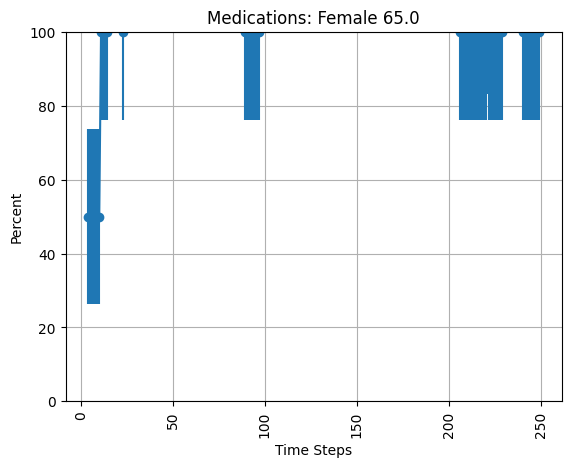

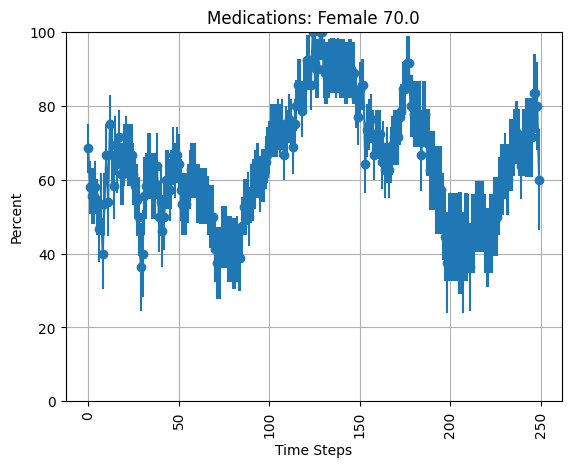

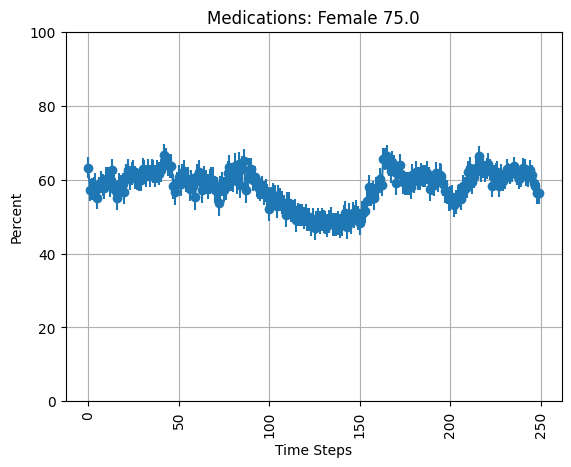

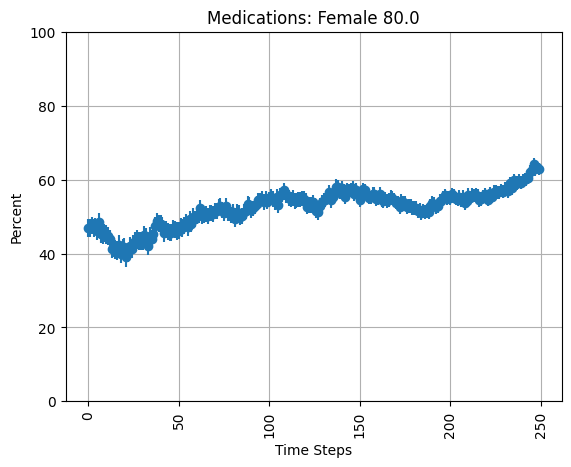

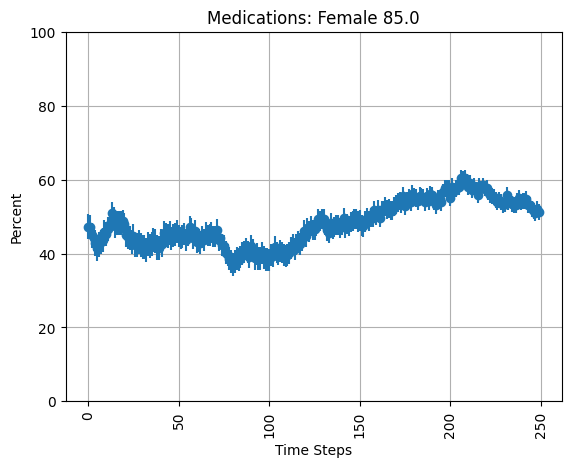

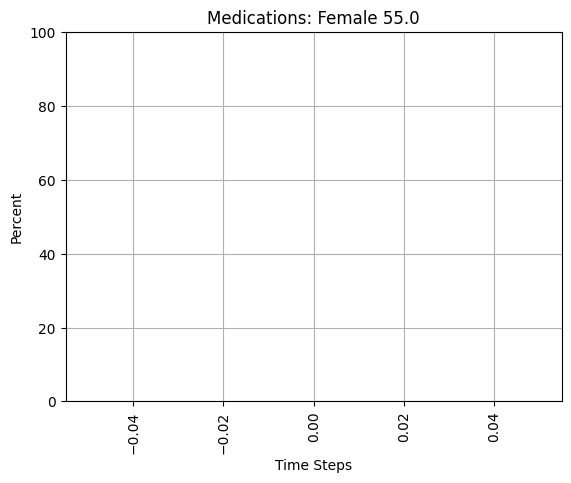

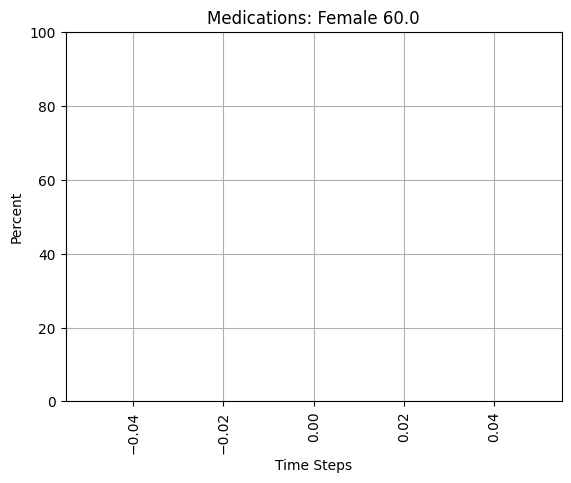

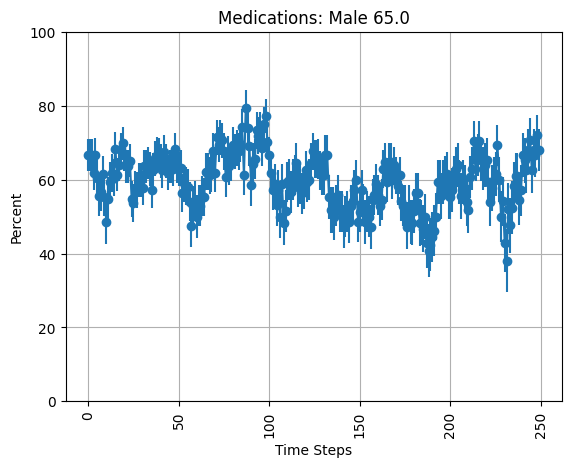

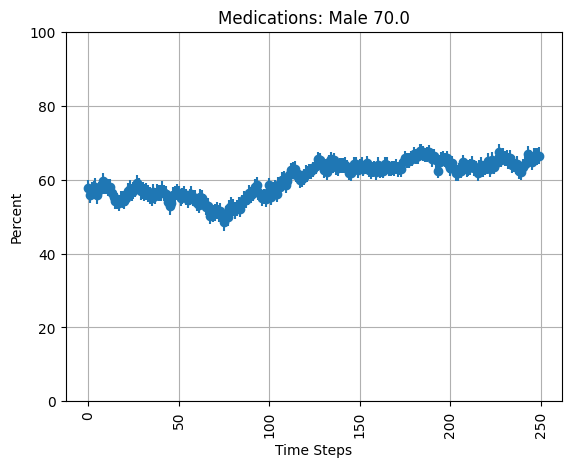

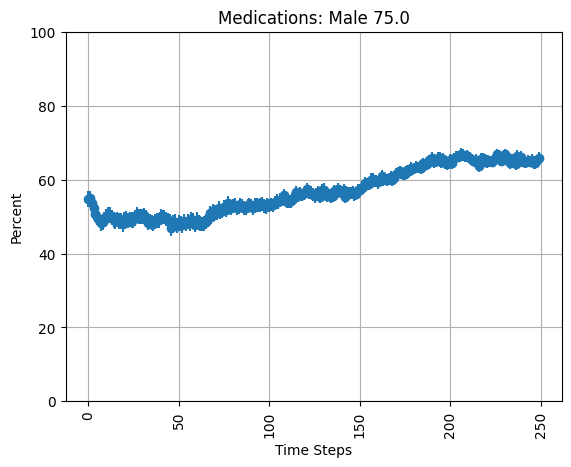

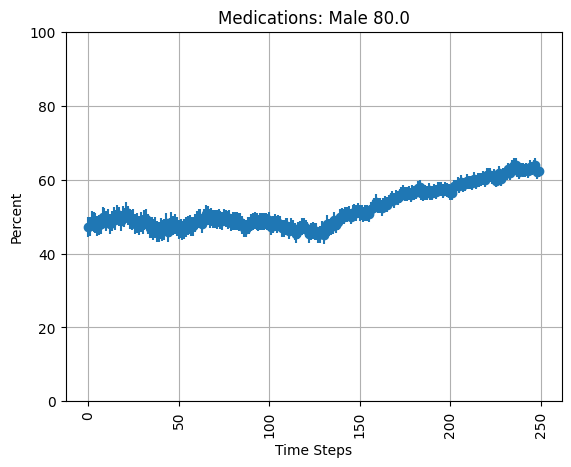

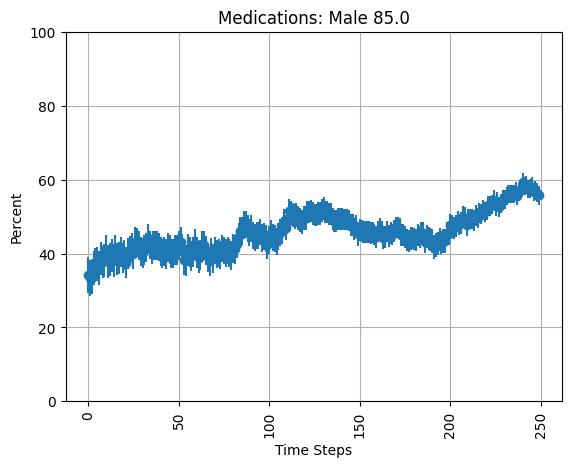

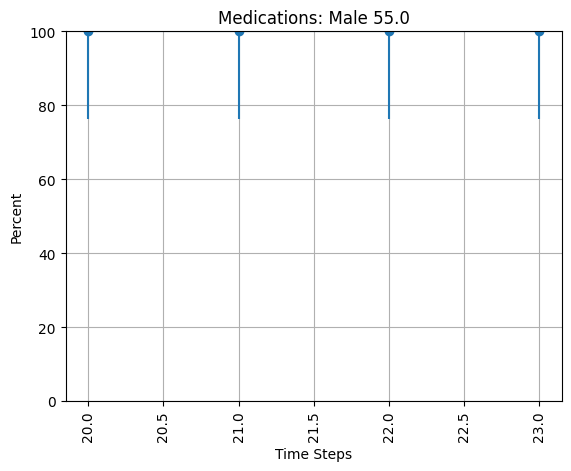

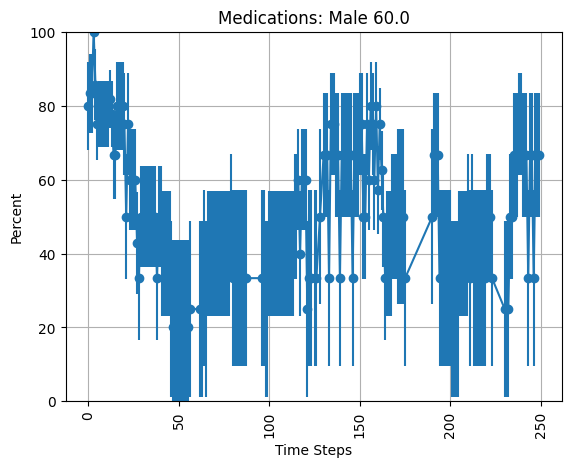

In [15]:
for sex in percentages.sex.unique():
    for age in percentages.age_start.unique():
        if age < 50 or age > 85:
            continue
            
        plt.figure() 
        no_trt = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.ldlc_medication=='no_treatment')]
        plt.errorbar(no_trt['step'], no_trt[0], yerr=no_trt['final_error'], marker='o')
        #one_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_half_dose_efficacy')]
        #plt.plot(one_half['step'], one_half[0], marker='o')
        #one_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_std_dose_efficacy')]
        #plt.plot(one_std['step'], one_std[0], marker='o')
        #two_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_half_dose_efficacy')]
        #plt.plot(two_half['step'], two_half[0], marker='o')
        #two_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_std_dose_efficacy')]
        #plt.plot(two_std['step'], two_std[0], marker='o')
        #three_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_half_dose_efficacy')]
        #plt.plot(three_half['step'], three_half[0], marker='o')
        #three_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_std_dose_efficacy')]
        #plt.plot(three_std['step'], three_std[0], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.ylabel('Percent')
        plt.xlabel('Time Steps')
        #plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.axis(ymin=0, ymax=100)